# **ANMOL CHAUBEY 24MAI0111**

For completing this task I have taken the dataset which contains the view of customer experiences, providing valuable insights for product improvement, marketing strategies, and customer relationship management.

1.) Importing the required libraries

In [54]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

2.) Create a Spark session

In [55]:
spark = SparkSession.builder \
    .appName("Customer Feedback Analysis") \
    .getOrCreate()

#3.) Data Ingestion

Load data from CSV

In [56]:
feedback_df = spark.read.csv("sentiment.csv", header=True, inferSchema=True)

Show the schema of the DataFrame

In [57]:
feedback_df.printSchema()

root
 |-- Review Title: string (nullable = true)
 |-- Customer name: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Category: string (nullable = true)
 |-- Comments: string (nullable = true)
 |-- Useful: integer (nullable = true)



 Data Cleaning

In [58]:

def clean_comment(comment):
    if comment:
        return comment.replace('\n', ' ').strip()
    return ""

Register the UDF for cleaning comments

In [59]:
clean_comment_udf = F.udf(clean_comment)

Clean comments in the DataFrame

In [60]:
cleaned_feedback_df = feedback_df.withColumn("Cleaned_Comment", clean_comment_udf(F.col("Comments")))


Sentiment Analysis

In [61]:
def analyze_sentiment(comment):
    analysis = TextBlob(comment)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

Register the UDF for sentiment analysis

In [62]:
analyze_sentiment_udf = F.udf(analyze_sentiment)

Analyze sentiment and create a new column

In [63]:
sentiment_distribution_df = cleaned_feedback_df.withColumn("Sentiment", analyze_sentiment_udf(F.col("Cleaned_Comment")))

Ensure Rating column is of type Double

In [64]:
sentiment_distribution_df = sentiment_distribution_df.withColumn("Rating", F.col("Rating").cast(DoubleType()))

 Trend Analysis


Feedback trends over time

In [65]:
trend_data = sentiment_distribution_df.groupBy(F.to_date(F.col("Date")).alias("Date")).agg(F.count("Customer name").alias("Feedback_Count"))
trend_data_pd = trend_data.toPandas()

Average ratings per category

In [66]:
avg_rating_per_category = sentiment_distribution_df.groupBy("Category").agg(F.avg("Rating").alias("Average_Rating"))
avg_rating_per_category_pd = avg_rating_per_category.toPandas()


Check if the DataFrames have any data before printing

In [67]:
if not avg_rating_per_category_pd.empty:
    print("Average Ratings DataFrame:\n", avg_rating_per_category_pd)
else:
    print("No data available in Average Ratings DataFrame.")

if not trend_data_pd.empty:
    print("Trend Data DataFrame:\n", trend_data_pd)
else:
    print("No data available in Trend Data DataFrame.")

Average Ratings DataFrame:
       Category  Average_Rating
0  Electronics        3.571429
1  Accessories        3.666667
Trend Data DataFrame:
          Date  Feedback_Count
0  2023-01-11               1
1  2023-01-12               1
2  2023-01-13               1
3  2023-01-14               1
4  2023-01-16               1
5  2023-01-15               1
6  2023-01-10               1
7  2023-01-17               1
8  2023-01-18               1
9  2023-01-19               1


Data Visualization


In [68]:
def visualize_sentiment_distribution(sentiment_df):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=sentiment_df.toPandas(), x='Sentiment', palette='Set2')
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

In [69]:
def visualize_average_ratings(avg_rating_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=avg_rating_df, x='Category', y='Average_Rating', palette='Set2')
    plt.title("Average Ratings per Category")
    plt.xlabel("Category")
    plt.ylabel("Average Rating")
    plt.xticks(rotation=45)
    plt.show()

In [70]:
def visualize_trends_over_time(trend_df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=trend_df, x='Date', y='Feedback_Count', marker='o')
    plt.title("Feedback Trends Over Time")
    plt.xlabel("Date")
    plt.ylabel("Feedback Count")
    plt.xticks(rotation=45)
    plt.show()

Generate visualizations

<ipython-input-68-8ab3fee53020>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sentiment_df.toPandas(), x='Sentiment', palette='Set2')


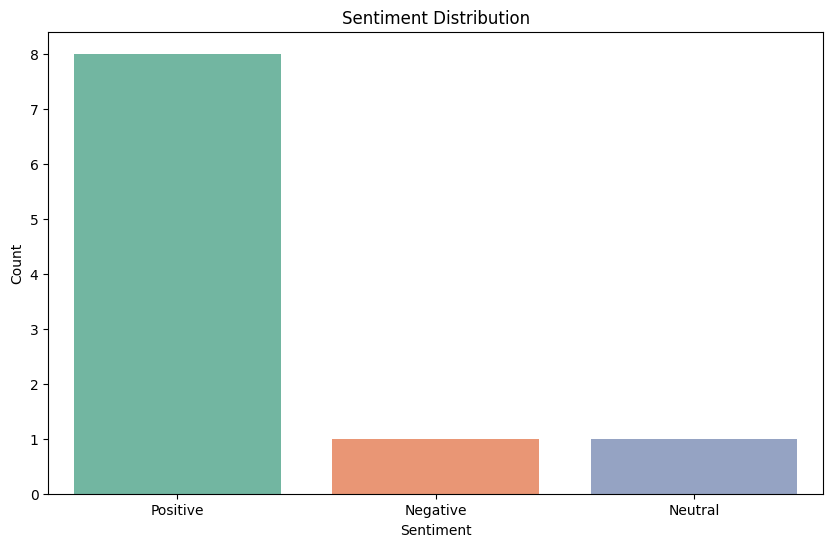

<ipython-input-69-9d5bad8bb14d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_rating_df, x='Category', y='Average_Rating', palette='Set2')


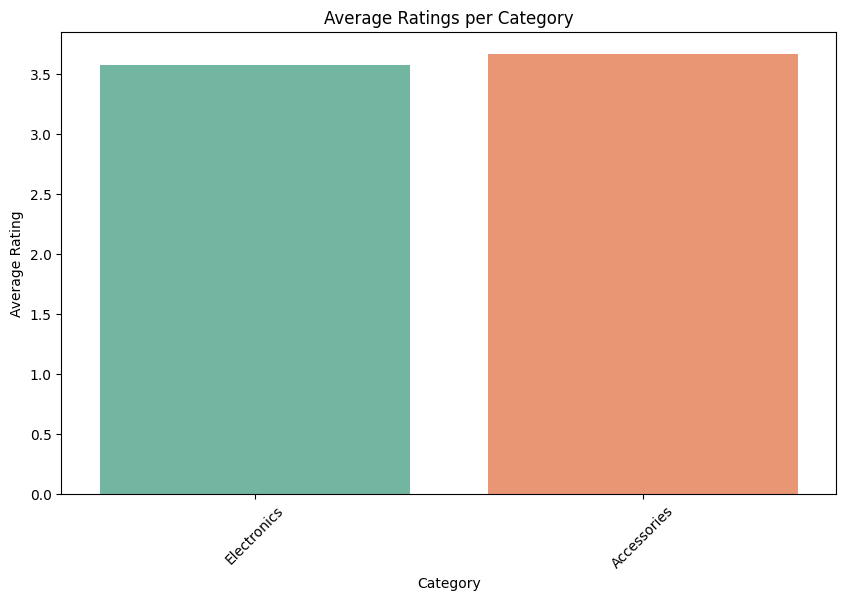

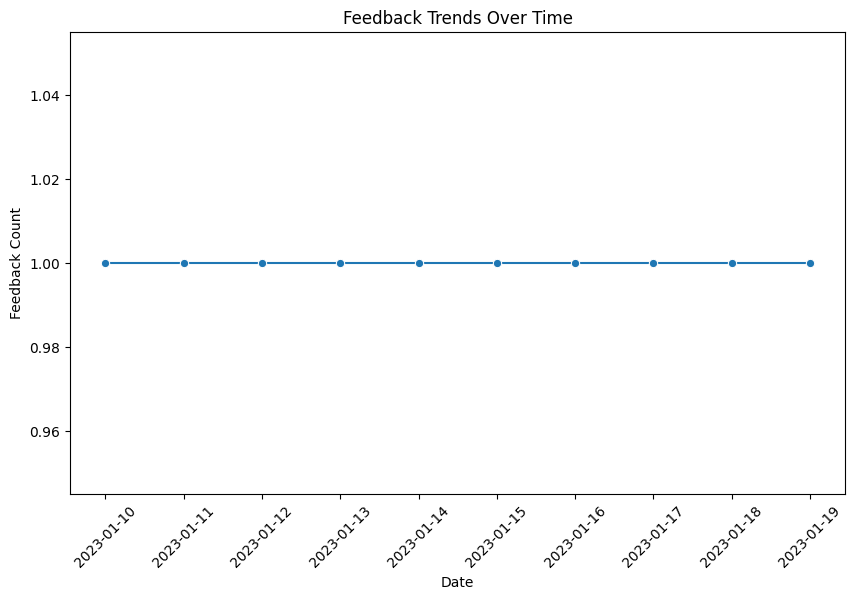

In [71]:
visualize_sentiment_distribution(sentiment_distribution_df)
visualize_average_ratings(avg_rating_per_category_pd)
visualize_trends_over_time(trend_data_pd)

Stop the Spark session

In [52]:
spark.stop()